In [122]:
import pandas as pd
import numpy as np
rng = np.random.default_rng(seed=5650)
import matplotlib.pyplot as plt
import seaborn as sns
cb_palette = ['#e69f00','#56b4e9','#009e73']
sns.set_palette(cb_palette)
import patchworklib as pw;
import pymc as pm
import arviz as az

### [Part 0] Our Simulated Coin Flips

In [136]:
all_flip_results = list(np.random.default_rng(seed=5650).binomial(n=1, p=0.5, size=250))
np.mean(all_flip_results)

0.5

Or truly random flips (from random.org), if preferred

In [141]:
true_random_flips = [
    1,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,1,0,1,0,0,0,0,1,1,0,1,1,1,0,0,1,0,
    1,1,1,0,0,0,1,0,0,0,0,1,1,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,1,0,0,
    1,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,1
]
np.mean(true_random_flips)

0.49

In [137]:
one_flip_result = all_flip_results[:1]
one_flip_result

[0]

In [138]:
two_flips_result = all_flip_results[:2]
two_flips_result

[0, 1]

In [139]:
five_flips_result = all_flip_results[:5]
five_flips_result

[0, 1, 0, 0, 1]

In [140]:
ten_flips_result = all_flip_results[:10]
ten_flips_result

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0]

## [Part 1] Informative (Beta) Prior Model

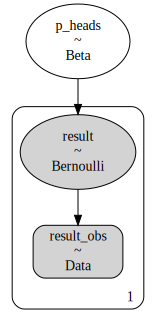

In [51]:
with pm.Model() as inf_model:
    result_obs = pm.Data('result_obs', one_flip_result)
    p_heads = pm.Beta("p_heads", alpha=2, beta=2)
    result = pm.Bernoulli("result", p=p_heads, observed=result_obs)
pm.model_to_graphviz(inf_model)

In [52]:
def draw_prior_sample(model, return_idata=False):
    with model:
        prior_idata = pm.sample_prior_predictive(draws=5000, random_seed=5650)
    prior_df = prior_idata.prior.to_dataframe().reset_index().drop(columns='chain')
    if return_idata:
        return prior_idata, prior_df
    return prior_df
inf_n0_df = draw_prior_sample(inf_model)

Sampling: [p_heads, result]


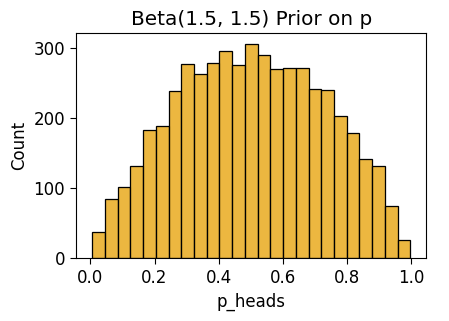

In [53]:
def gen_dist_plot(dist_df, plot_title):
    ax = pw.Brick(figsize=(3.5, 2.25))
    sns.histplot(
        x="p_heads", data=dist_df, ax=ax,
        bins=25
    );
    ax.set_title(plot_title)
    return ax
inf_n0_plot = gen_dist_plot(inf_n0_df, "Beta(1.5, 1.5) Prior on p")
inf_n0_plot.savefig()

In [54]:
def draw_post_sample(model, num_draws=5000):
    with model:
        post_idata = pm.sample(draws=num_draws, random_state=5650)
    post_df = post_idata.posterior.to_dataframe().reset_index().drop(columns='chain')
    return post_df
inf_n1_df = draw_post_sample(inf_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


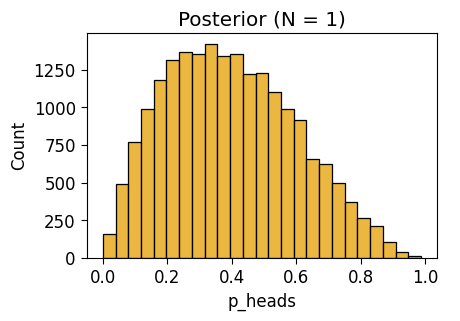

In [55]:
inf_n1_plot = gen_dist_plot(inf_n1_df, "Posterior (N = 1)")
inf_n1_plot.savefig()

### Observe $N = 2$ Flips

In [56]:
with inf_model:
    pm.set_data({'result_obs': two_flips_result})
inf_n2_df = draw_post_sample(inf_model)    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


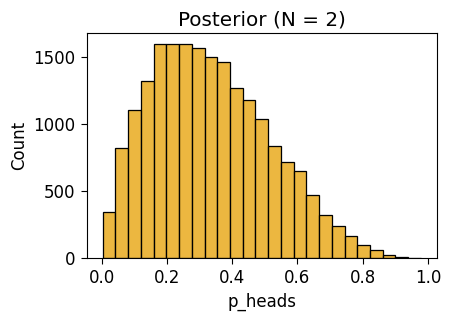

In [57]:
inf_n2_plot = gen_dist_plot(inf_n2_df, "Posterior (N = 2)")
inf_n2_plot.savefig()

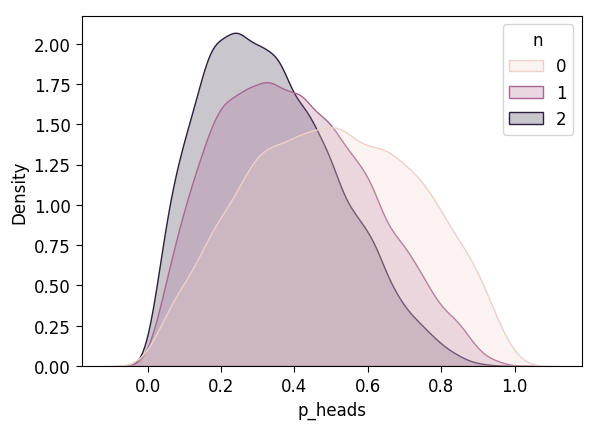

In [58]:
def plot_n_dists(n_df):
    ax = pw.Brick(figsize=(5, 3.5));
    sns.kdeplot(
        x="p_heads", hue="n", fill=True, ax=ax, data=n_df,
        common_norm=False
    );
    display(ax.savefig())
inf_n0_df['n'] = 0
inf_n1_df['n'] = 1
inf_n2_df['n'] = 2
inf_3_df = pd.concat([inf_n0_df, inf_n1_df, inf_n2_df])
plot_n_dists(inf_3_df)

### Observe $N = 5$ Flips

In [59]:
with inf_model:
    pm.set_data({'result_obs': five_flips_result})
inf_n5_df = draw_post_sample(inf_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


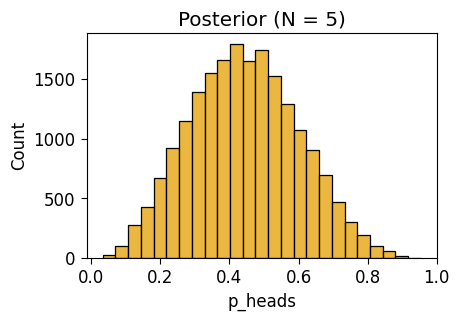

In [60]:
inf_n5_plot = gen_dist_plot(inf_n5_df, "Posterior (N = 5)")
inf_n5_plot.savefig()

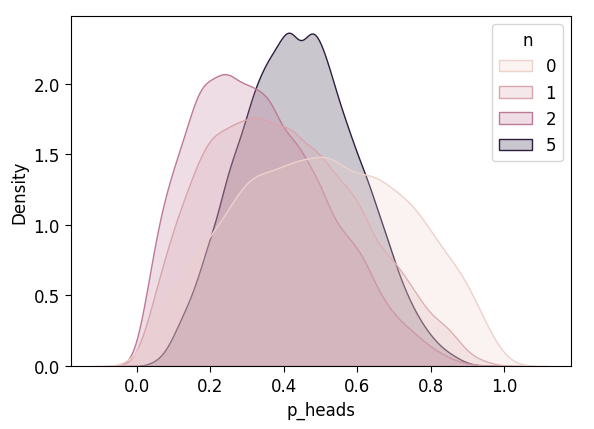

In [63]:
inf_n5_df['n'] = 5
inf_4_df = pd.concat([inf_3_df, inf_n5_df])
plot_n_dists(inf_4_df)

### Observe $N = 10$ Flips

In [62]:
with inf_model:
    pm.set_data({'result_obs': ten_flips_result})
inf_n10_df = draw_post_sample(inf_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


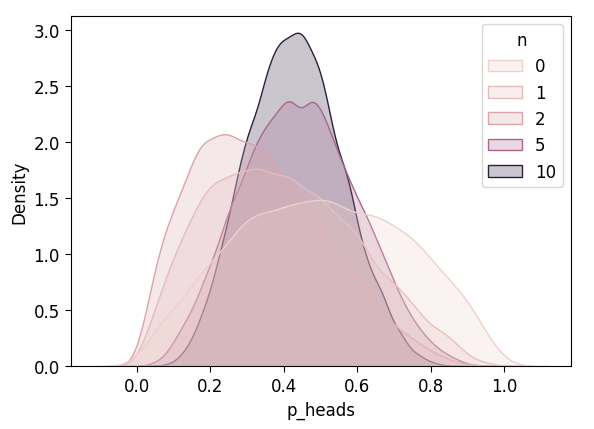

In [64]:
inf_n10_df['n'] = 10
inf_5_df = pd.concat([inf_4_df, inf_n10_df])
plot_n_dists(inf_5_df)

### Observe $N = 25$ Flips

## [Part 2] Flat (Uniform) Prior

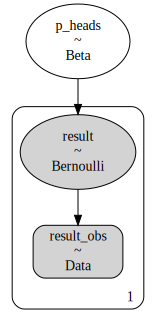

In [65]:
with pm.Model() as unif_model:
    result_obs = pm.Data('result_obs', one_flip_result)
    p_heads = pm.Beta("p_heads", 1, 1)
    result = pm.Bernoulli("result", p=p_heads, observed=result_obs)
pm.model_to_graphviz(unif_model)

In [66]:
unif_n0_df = draw_prior_sample(unif_model)

Sampling: [p_heads, result]


,draw,p_heads
0,0,0.970164
1,1,0.085831
2,2,0.101310
3,3,0.315523
4,4,0.285908
...,...,...
4995,4995,0.254631
4996,4996,0.166792
4997,4997,0.772046
4998,4998,0.296384


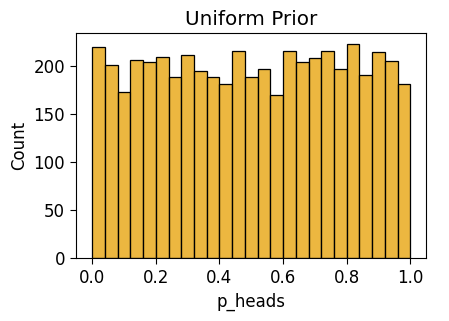

In [67]:
unif_n0_plot = gen_dist_plot(unif_n0_df, "Uniform Prior")
unif_n0_plot.savefig()

### Posterior After $N = 1$ Observed Flips

In [68]:
unif_n1_df = draw_post_sample(unif_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


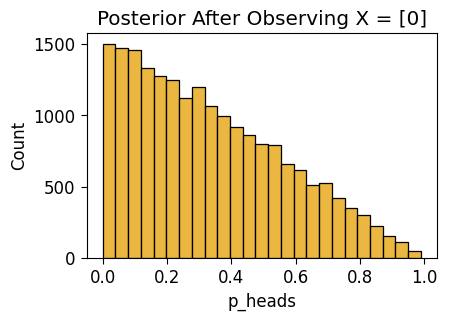

In [69]:
unif_n1_plot = gen_dist_plot(unif_n1_df, f"Posterior After Observing X = {one_flip_result}")
unif_n1_plot.savefig()

### Posterior After $N = 2$ Flips

In [70]:
with unif_model:
    pm.set_data({'result_obs': two_flips_result})
unif_n2_df = draw_post_sample(unif_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


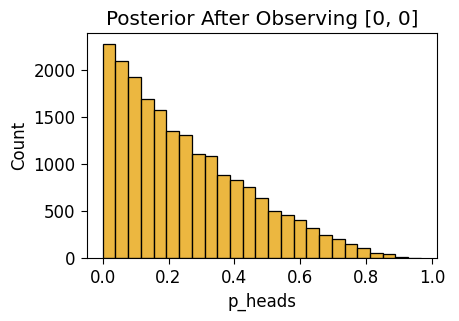

In [71]:
unif_n2_plot = gen_dist_plot(unif_n2_df, f"Posterior After Observing {two_flips_result}")
unif_n2_plot.savefig()

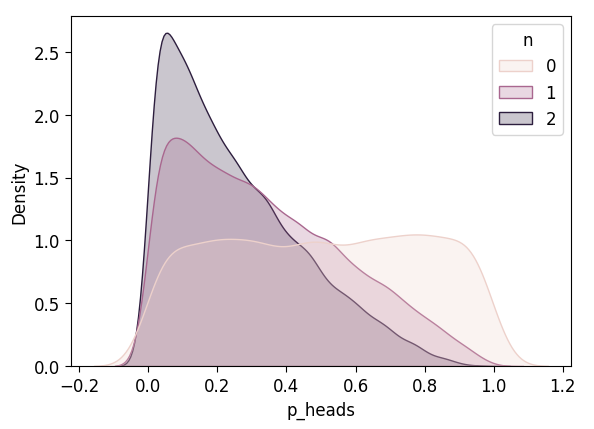

In [72]:
unif_n0_df['n'] = 0
unif_n1_df['n'] = 1
unif_n2_df['n'] = 2
unif_3_df = pd.concat([unif_n0_df, unif_n1_df, unif_n2_df])
plot_n_dists(unif_3_df)

In [73]:
with unif_model:
    pm.set_data({'result_obs': five_flips_result})
unif_n5_df = draw_post_sample(unif_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


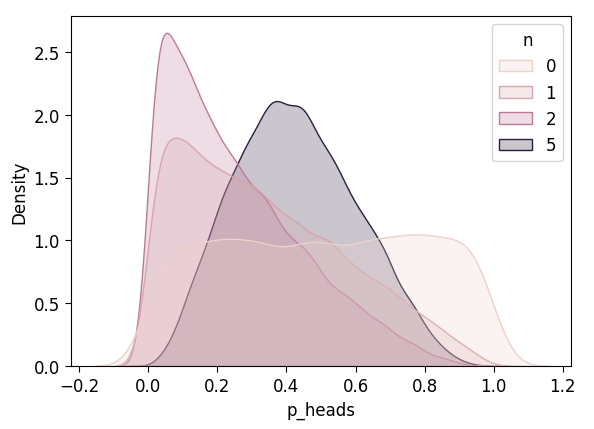

In [76]:
unif_n5_df['n'] = 5
unif_4_df = pd.concat([unif_3_df, unif_n5_df])
plot_n_dists(unif_4_df)

### Observe $N = 10$ Flips

In [77]:
with unif_model:
    pm.set_data({'result_obs': ten_flips_result})
unif_n10_df = draw_post_sample(unif_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


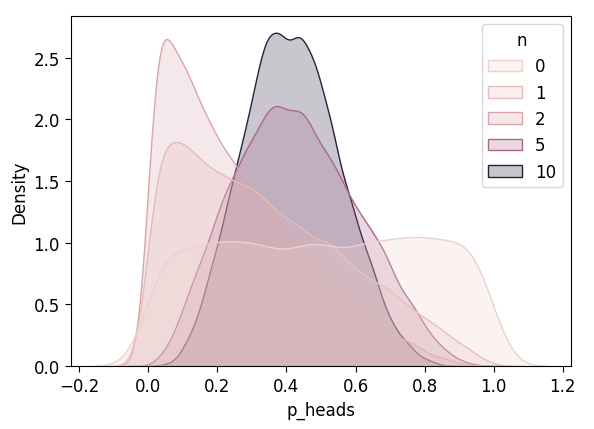

In [78]:
unif_n10_df['n'] = 10
unif_5_df = pd.concat([unif_4_df, unif_n10_df])
plot_n_dists(unif_5_df)

## [Part 3] Skeptical (Jeffreys) Prior

This prior is itself derived from an approach to Bayesian statistics called "Objective Bayes", within which the [Jeffreys Prior for the Bernoulli parameter $p$](https://en.wikipedia.org/wiki/Jeffreys_prior#Bernoulli_trial) has a special status.

For our purposes, however, we can just view it as a "skeptical" prior: it encodes an assumption that the coin is **very biased**, i.e., that before seeing any actual coin flips we think that $p = 0$ and $p = 1$ are more likely than any of the values in between (any of the values $p \in (0, 1)$). This means that---*relative to* the Beta and Uniform cases---someone with these priors would require a **very "even" mixture** of heads and tails to "cancel out" their pre-existing belief that the coin is biased!

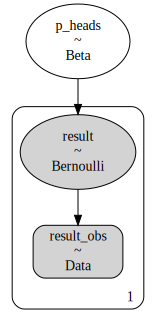

In [79]:
with pm.Model() as flat_model:
    result_obs = pm.Data('result_obs', one_flip_result)
    p_heads = pm.Beta("p_heads", 0.5, 0.5)
    result = pm.Bernoulli("result", p=p_heads, observed=result_obs)
pm.model_to_graphviz(flat_model)

In [80]:
flat_n0_df = draw_prior_sample(flat_model)

Sampling: [p_heads, result]


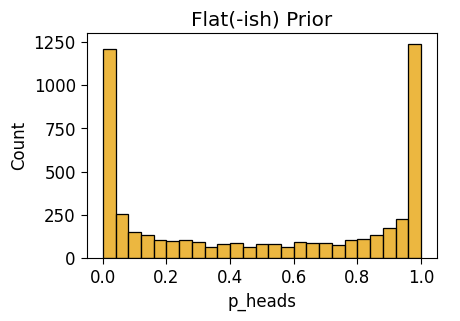

In [81]:
flat_n0_plot = gen_dist_plot(flat_n0_df, "Flat(-ish) Prior")
flat_n0_plot.savefig()

### Observe $N = 1$ Flip

In [82]:
flat_n1_df = draw_post_sample(flat_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


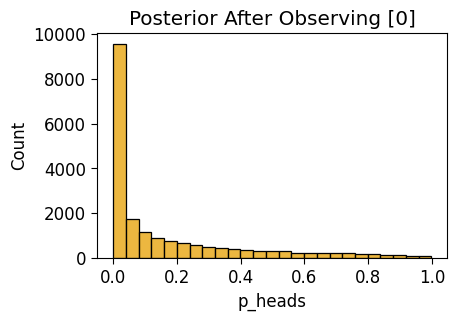

In [84]:
flat_n1_plot = gen_dist_plot(flat_n1_df, f"Posterior After Observing {one_flip_result}")
flat_n1_plot.savefig()

### Observe $N = 2$ Flips

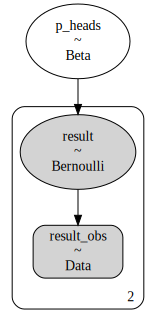

In [85]:
with flat_model:
    pm.set_data({'result_obs': two_flips_result})
pm.model_to_graphviz(flat_model)

In [86]:
flat_n2_df = draw_post_sample(flat_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


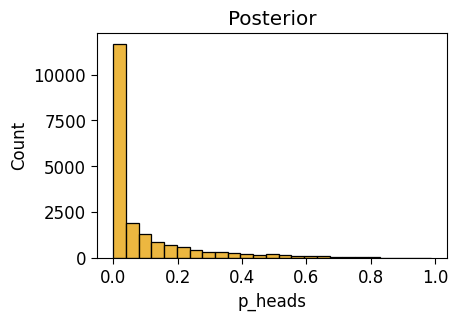

In [87]:
flat_n2_plot = gen_dist_plot(flat_n2_df, "Posterior")
flat_n2_plot.savefig()

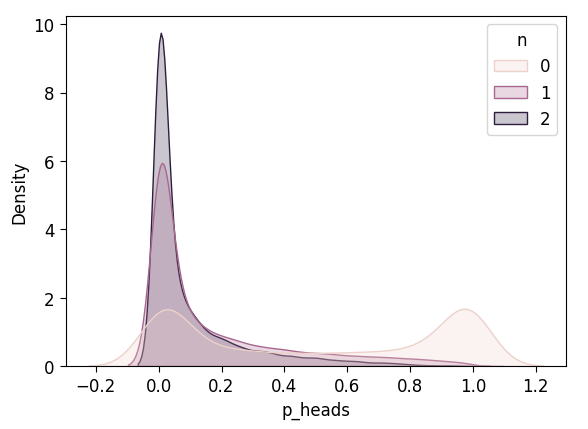

In [88]:
flat_n0_df['n'] = 0
flat_n1_df['n'] = 1
flat_n2_df['n'] = 2
flat_3_df = pd.concat([flat_n0_df, flat_n1_df, flat_n2_df])
plot_n_dists(flat_3_df)

In [89]:
with flat_model:
    pm.set_data({'result_obs': five_flips_result})
flat_n5_df = draw_post_sample(flat_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


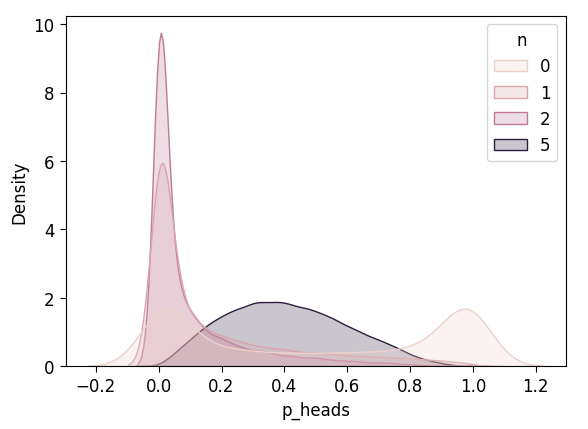

In [90]:
flat_n5_df['n'] = 5
flat_4_df = pd.concat([flat_3_df, flat_n5_df])
plot_n_dists(flat_4_df)

### Observe $N = 10$ Flips

In [91]:
with flat_model:
    pm.set_data({'result_obs': ten_flips_result})
flat_n10_df = draw_post_sample(flat_model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_heads]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


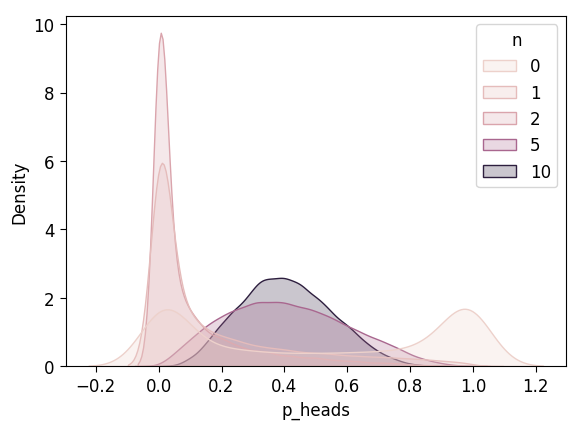

In [92]:
flat_n10_df['n'] = 10
flat_5_df = pd.concat([flat_4_df, flat_n10_df])
plot_n_dists(flat_5_df)

## [Part 4] Which One Learned Most Efficiently?

### After $N = 2$?

In [93]:
def plot_dist_comparison(combined_df):
    ax = pw.Brick(figsize=(5, 3.5));
    sns.kdeplot(
        x="p_heads", hue="prior", fill=True, ax=ax, data=combined_df,
        common_norm=False
    );
    display(ax.savefig())

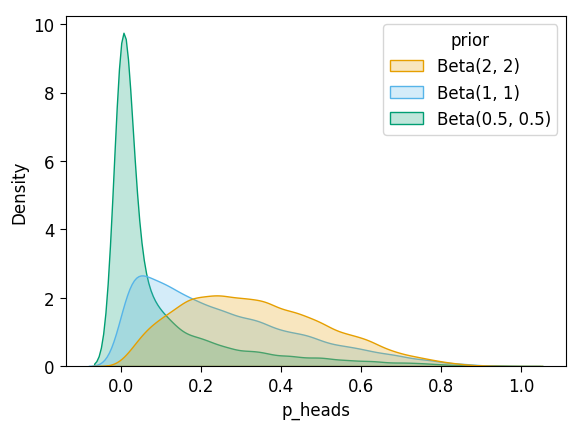

In [94]:
inf_n2_df['prior'] = 'Beta(2, 2)'
unif_n2_df['prior'] = 'Beta(1, 1)'
flat_n2_df['prior'] = 'Beta(0.5, 0.5)'
all_n2_df = pd.concat([inf_n2_df, unif_n2_df, flat_n2_df])
plot_dist_comparison(all_n2_df)

### After $N = 5$?

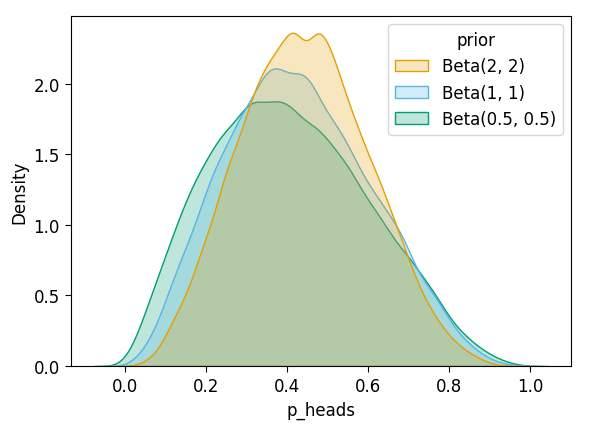

In [96]:
inf_n5_df['prior'] = 'Beta(2, 2)'
unif_n5_df['prior'] = 'Beta(1, 1)'
flat_n5_df['prior'] = 'Beta(0.5, 0.5)'
all_n5_df = pd.concat([inf_n5_df, unif_n5_df, flat_n5_df])
plot_dist_comparison(all_n5_df)

### After $N = 10$?

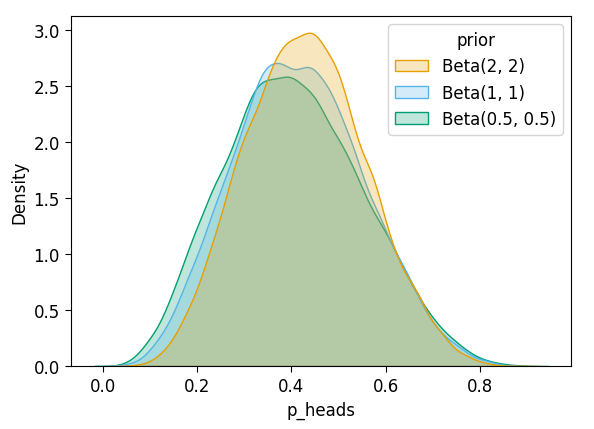

In [97]:
inf_n10_df['prior'] = 'Beta(2, 2)'
unif_n10_df['prior'] = 'Beta(1, 1)'
flat_n10_df['prior'] = 'Beta(0.5, 0.5)'
all_n10_df = pd.concat([inf_n10_df, unif_n10_df, flat_n10_df])
plot_dist_comparison(all_n10_df)

In [98]:
with inf_model:
    print(pm.find_MAP())

Output()

{'p_heads_logodds__': array(-0.33647223), 'p_heads': array(0.41666667)}


In [99]:
with unif_model:
    print(pm.find_MAP())

Output()

{'p_heads_logodds__': array(-0.4054651), 'p_heads': array(0.4)}


In [100]:
with flat_model:
    print(pm.find_MAP())

Output()

{'p_heads_logodds__': array(-0.47956846), 'p_heads': array(0.38235403)}
